In [ ]:
import numpy as np
import pandas as pd

import re
import string
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving True.csv to True.csv
Saving Fake.csv to Fake.csv
User uploaded file "True.csv" with length 53582940 bytes
User uploaded file "Fake.csv" with length 62789876 bytes


In [ ]:
fake=pd.read_csv('Fake.csv')
real=pd.read_csv('True.csv')

In [ ]:
# label the news
fake['label']=0
real['label']=1

# concat the datasets
df=pd.concat([fake,real],ignore_index=True)

# shuffle the dataset
df= df.sample(frac=1).reset_index(drop=True)

df.info()
display(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


,title,text,subject,date,label
0,Chaffetz Says Congress ‘Needs To See’ Comey M...,The Trump administration is in a tailspin afte...,News,"May 16, 2017",0
1,U.S. carrier patrols off Korean peninsula in w...,"ABOARD USS RONALD REAGAN, Sea of Japan (Reuter...",worldnews,"October 19, 2017",1


In [ ]:
%pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=416fff9d693f7cb6458b0fe8ae09dd7a8cd14a58311934c01bda68468702bdb1
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [ ]:
import swifter


In [ ]:
nlp = spacy.load("en_core_web_sm")

def clean_text_spacy(text):
    doc = nlp(text.lower())

    cleaned_tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]

    return " ".join(cleaned_tokens)

df["cleaned_text"] = df["text"].swifter.apply(clean_text_spacy)

Pandas Apply:   0%|          | 0/44898 [00:00<?, ?it/s]

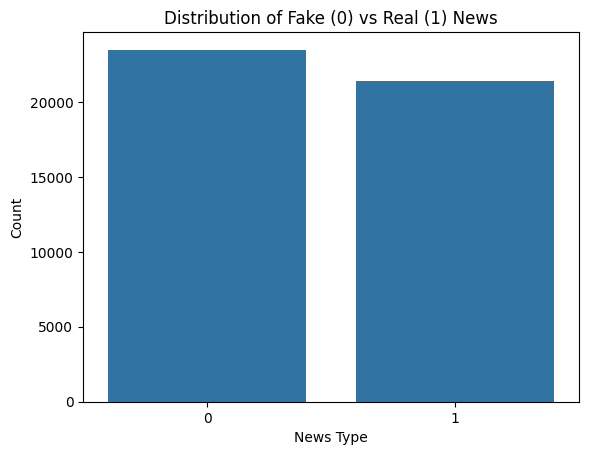

In [ ]:
sns.countplot(df,x='label')
plt.title('Distribution of Fake (0) vs Real (1) News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

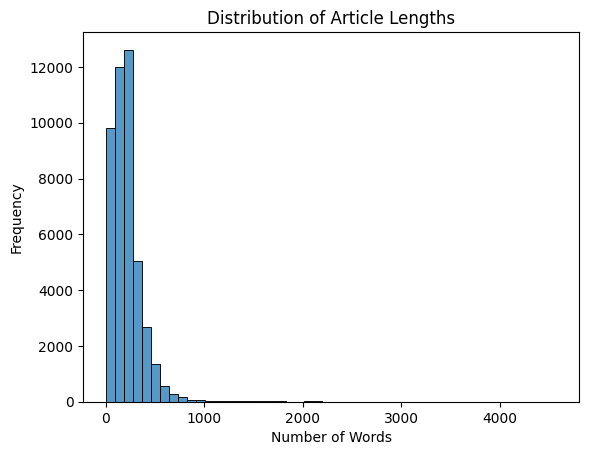

In [ ]:
df['cleaned_text']=df['cleaned_text'].astype(str)
df['text_length']=df['cleaned_text'].apply(lambda a : len(a.split()))

sns.histplot(df,x='text_length',bins=50)
plt.title("Distribution of Article Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

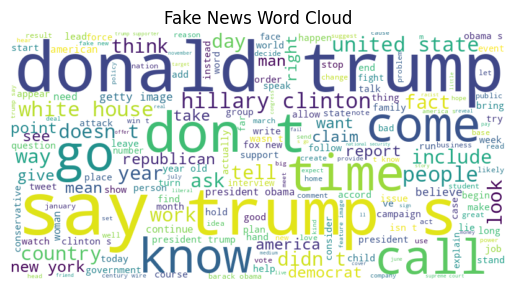

In [ ]:
# word cloud for fake news

fake_text=' '.join(df[df['label']==0]['cleaned_text'])
wc_fake=WordCloud(width=800,height=400,background_color='white').generate(fake_text)

plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")
plt.show()

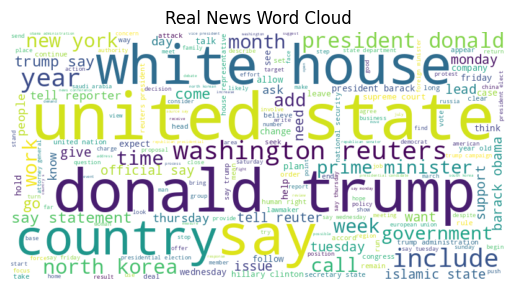

In [ ]:
real_text=' '.join(df[df['label']==1]['cleaned_text'])
wc_real=WordCloud(width=800,height=400,background_color='white').generate(real_text)

plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title("Real News Word Cloud")
plt.show()

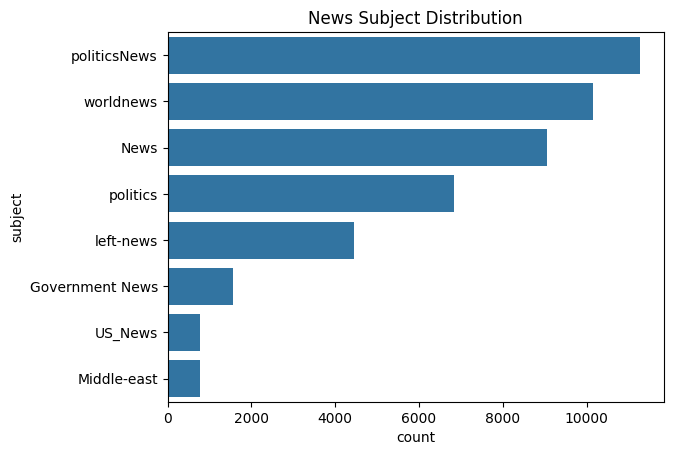

In [ ]:
sns.countplot(data=df,y='subject',order=df['subject'].value_counts().index)
plt.title('News Subject Distribution')
plt.show()


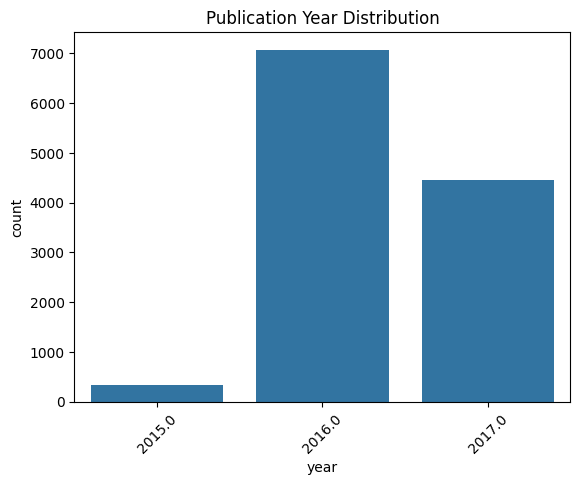

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

sns.countplot(data=df, x='year')
plt.title('Publication Year Distribution')
plt.xticks(rotation=45)
plt.show()


In [ ]:
tfidf=TfidfVectorizer(max_features=5000)
X=tfidf.fit_transform(df['cleaned_text'])
y=df['label']

In [ ]:
feature_names = tfidf.get_feature_names_out()

tfidf_matrix = X.toarray()

top_n = 10
row = 0  # Choose an article index
top_indices = np.argsort(tfidf_matrix[row])[::-1][:top_n]
top_terms = [feature_names[i] for i in top_indices]

print("Top TF-IDF terms for sample article:")
print(top_terms)

Top TF-IDF terms for sample article:
['memo', 'chaffetz', 'comey', 'subpoena', 'exist', 'pen', 'jason', 'senator', 'maybe', 'ready']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4771
           1       0.98      0.99      0.98      4209

    accuracy                           0.99      8980
   macro avg       0.98      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



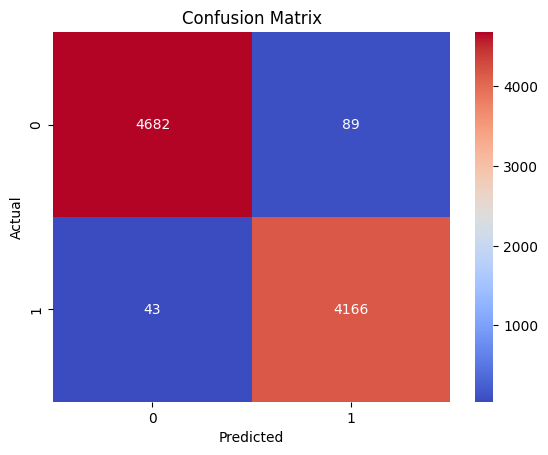

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import pickle

# Save model and vectorizer
with open('fake_news_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [ ]:
# Load model and vectorizer
model = pickle.load(open('fake_news_model.pkl', 'rb'))
vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))

def predict_news(text):
    vec = vectorizer.transform([text])
    prediction = model.predict(vec)
    return 'Real' if prediction[0] == 1 else 'Fake'

print(predict_news("United States was captured by Russia"))


Fake
